<a href="https://colab.research.google.com/github/tmcarn/deforestation_detection/blob/main/Deforestation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# ! cd /drive/MyDrive/deforestation_dataset

# dataset_url = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/24761/2001871/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1750106825&Signature=ohGweTzossiJSZ9maxN0ipmy6QPqCLHoGQgG41jqqNXrGkcbeSSAgGH5KZyvgPxdtl4LnJuq1w7vJXUV3QyNIpXgQ9Ehg3q40BKZ0Sq0hb9YdvLQGhPTmYeoNVpOwqXTnSMHlfQO8Dv4qxef%2BapSe%2FCPaMvCYScNKSV9RV1D6ONVAfvg%2BEG%2BM4ikU%2Ffu%2BhUr8MZkBWwL74lOXbEbyXiqJy7HZqNm2b0mFPF%2BdY2q0Ghb4KA0dsaLY1%2BzcdwU6n31hBWU2ui4IHq6j%2FfgRPu%2Bq5cQM0QGsG8PP1atID7sTKaHIH7G%2FKKDR159UbpgWZtFl5ZRAFRHEyjL88VvdR%2B5Ng%3D%3D&response-content-disposition=attachment%3B+filename%3Ddeforestation.zip"
# wget.download(dataset_url)

# ! unzip deforestation.zip


Mounted at /content/drive


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm
import albumentations as A

json_path = 'drive/MyDrive/deforestation_dataset/train.json'
path = 'drive/MyDrive/deforestation_dataset/train/public'

with open(json_path, 'r') as file:
    metadata = json.load(file)

In [31]:
# Partition Dataset

# 80% --> Training
# 5% --> Validation
# 15% --> Testing

p_train = 0.8
p_val = 0.05

index = np.arange(len(metadata))
np.random.shuffle(index)

n_samples = len(metadata)

n_train = int(0.8 * n_samples)
train_index = index[:n_train]

n_val = int(0.1 * n_samples)
val_index = index[n_train:n_train+n_val]

test_index = index[n_train+n_val:]

# Store path names of each file for each split
splits = [train_index, val_index, test_index]

train_paths = [[],[],[]]
val_paths = [[],[],[]]
test_paths = [[],[],[]]

for split_idxs, split_paths in zip(splits,[train_paths, val_paths, test_paths]):
    for idx in split_idxs:
        key = str(idx)

        first_path = metadata[key]['files']['satellite_img_first']
        second_path = metadata[key]['files']['satellite_img_second']
        mask_path = metadata[key]['files']['mask']

        split_paths[0].append(os.path.join(path, first_path))
        split_paths[1].append(os.path.join(path, second_path))
        split_paths[2].append(os.path.join(path, mask_path))

train_paths = np.array(train_paths)
val_paths = np.array(val_paths)
test_paths = np.array(test_paths)

### Getting Class Weights

In [5]:
def calculate_class_weights(mask_paths):
    forested_count = 0  # forested
    def_count = 0  # deforested

    for path in mask_paths:
        mask = np.load(path)
        def_count += np.sum(mask == 1)
        forested_count += np.sum(mask == 0)

    total = forested_count + def_count

    print(f"Forested: {(forested_count/total)*100:.2f}%, Deforested: {(def_count/total)*100:.2f}%")

    # Inverse frequency: higher weight for underrepresented class
    def_weight = total / (2 * def_count)
    forest_weight = total / (2 * forested_count)

    return def_weight, forest_weight


In [6]:
def_weight, forest_weight = calculate_class_weights(train_paths[2])

print(f"Deforested Weight: {def_weight:.4f}")
print(f"Forested Weight: {forest_weight:.4f}")

Forested: 99.19%, Deforested: 0.81%
Deforested Weight: 61.7088
Forested Weight: 0.5041


### Build Dataset


In [34]:
from torch.utils.data import Dataset

class DeforestationDataset(Dataset):
    def __init__(self, split_paths, augmentation = None):
        self.before_paths = split_paths[0]
        self.after_paths = split_paths[1]
        self.mask_paths = split_paths[2]
        self.augmentation = augmentation

    def __len__(self):
      if len(self.before_paths) == len(self.after_paths) and len(self.before_paths) == len(self.mask_paths):
        return len(self.before_paths)
      else:
        raise ValueError("Input arrays must have the same length.")

    def __getitem__(self, idx):
        img1 = self.load_image(self.before_paths[idx])
        img2 = self.load_image(self.after_paths[idx])
        mask = self.load_mask(self.mask_paths[idx])

        images_stacked = np.concatenate((img1, img2), axis=2)
        print(images_stacked.shape)

        if self.augmentation:
          images_stacked = np.concatenate((img1, img2), axis=2)
          print(images_stacked.shape)

          images_stacked, mask = self.augmentation(images_stacked, mask)

        return img1, img2, mask

    def load_image(self, path):
      img = np.load(path).astype(np.float32)

      return self.preprocess(img)

    def load_mask(self, path):
      return np.load(path).astype(np.float32)

    def preprocess(self, img):
      '''
      input: img --> (H, W, C)
      output: img --> (C, H, W)
      '''
      img = img.transpose(2, 0, 1) # (H, W, C) ==> (C, H, W)

      # NDVI Channel
      red = img[3, :, :].astype(np.float32)
      nir = img[7, :, :].astype(np.float32)

      denominator = nir + red
      denominator[denominator == 0] = 1e-6 # Inhibits division error

      ndvi = (nir - red) / denominator

      ndvi = np.expand_dims(ndvi, axis=0)

      print(ndvi.shape)

      # Remove unneeded bands
      BANDS = [1,  # Blue
               2,  # Green
               3,  # Red
               7,  # NIR
               10, # SWIR 1
               11] # SWIR 2

      img = img[BANDS,:,:]

      # Add NDVI Channel
      img = np.concatenate((img, ndvi), axis=0)
      return img

    def augment(self, img1, img2, mask):
      flip_ud = np.flipud(img1)
      flip_lr = np.fliplr(img1)

      return flip_ud, flip_lr, mask



(1, 512, 512)
(1, 512, 512)


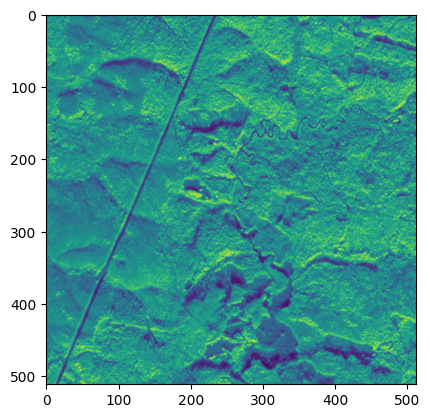

In [32]:
# Test Loader
testds = DeforestationDataset(train_paths)

img1, img2, mask = testds.__getitem__(0)

ndvi = img1[-1, :, :]

plt.imshow(ndvi)
plt.show()

In [57]:
# # Preprocess

# # Scale down to 256 x 256

# first = metadata[str(train_index[0])]['files']['satellite_img_first']
# second = metadata[str(train_index[0])]['files']['satellite_img_second']
# mask = metadata[str(train_index[0])]['files']['mask']

# first_img = np.load(os.path.join(path, first))

# print(first_img.shape)

# # tiles = [
# #     first_img[:256, :256, :],     # top-left
# #     first_img[:256, 256:512, :],  # top-right
# #     first_img[256:512, :256, :],  # bottom-left
# #     first_img[256:512, 256:512, :]# bottom-right
# #     ]


### Build Model Architecture

In [8]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))

### Define Loss Function

In [12]:
class WeightedDiceLoss(nn.Module):
    def __init__(self, def_weight, forest_weight, smooth=1.0):
        super(WeightedDiceLoss, self).__init__()
        self.smooth = smooth
        self.def_weight = def_weight
        self.forest_weight = forest_weight

    def forward(self, def_probs, targets):
        # Flatten tensors to simplify computation.
        def_probs = def_probs.reshape(-1)
        targets = targets.reshape(-1)

        def_mask = (targets == 1).float()
        forest_mask = (targets == 0).float()

        # deforested loss
        def_intersection = (def_probs * def_mask).sum()
        def_dice_score = (2.0 * def_intersection + self.smooth) / (def_probs[def_mask.bool()].sum() + def_mask.sum() + self.smooth)

        # forested loss
        forest_probs = 1 - def_probs
        forest_intersection = (forest_probs * forest_mask).sum()
        forest_dice_score = (2.0 * forest_intersection + self.smooth) / (forest_probs[forest_mask.bool()].sum() + forest_mask.sum() + self.smooth)

        dice_score = (self.def_weight * def_dice_score + self.forest_weight * forest_dice_score) / (self.def_weight + self.forest_weight) # Weighted sum

        return 1 - dice_score

In [15]:
# Test Loss Function
test_out = torch.full((1, 1, 512, 512), .99)  # logits → sigmoid ≈ 1
test_mask = torch.ones_like(test_out)

criterion = WeightedDiceLoss(def_weight, forest_weight)
loss = criterion(test_out, test_mask)

print(loss)


tensor(0.0050)


In [16]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    total_loss = 0
    # criterion = nn.BCELoss()
    loss_fn = WeightedDiceLoss(def_weight, forest_weight)

    for img1, img2, label in tqdm(train_dataloader, desc="Training", leave=False):
        x = torch.cat([img1, img2], dim=1).to(device)
        y = label.to(device).unsqueeze(1).float()  # shape: (B, 1, H, W)

        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    return total_loss / len(train_dataloader)

### Train Model


In [18]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=12).to(device)  # assuming 6 of 13 bands per image
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_ds = DeforestationDataset(train_paths)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

for epoch in range(10):
    loss = train_one_epoch(model, train_loader, optimizer, device)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [29]:
# Evaluate model

test_ds = DeforestationDataset(test_paths)

test_len = test_ds.__len__()

test_index = np.random.choice(np.arange(test_len), size=8, replace=False)
batch = []
mask_list = []

for i in test_index:
  img1, img2, mask = test_ds.__getitem__(i)
  img = torch.cat([torch.from_numpy(img1).unsqueeze(0), torch.from_numpy(img2).unsqueeze(0)], dim=1)
  batch.append(img)
  mask_list.append(mask)

batch = torch.from_numpy(np.array(batch)).squeeze(1)
print(batch.shape)

with torch.no_grad():
  model.eval()
  out = model(batch.to(device))

with torch.no_grad():
    model.eval()
    out = model(batch.to(device))

print(out.shape)


# with torch.no_grad():
#     model.eval()
#     total_loss = 0



torch.Size([8, 12, 512, 512])
torch.Size([8, 1, 512, 512])


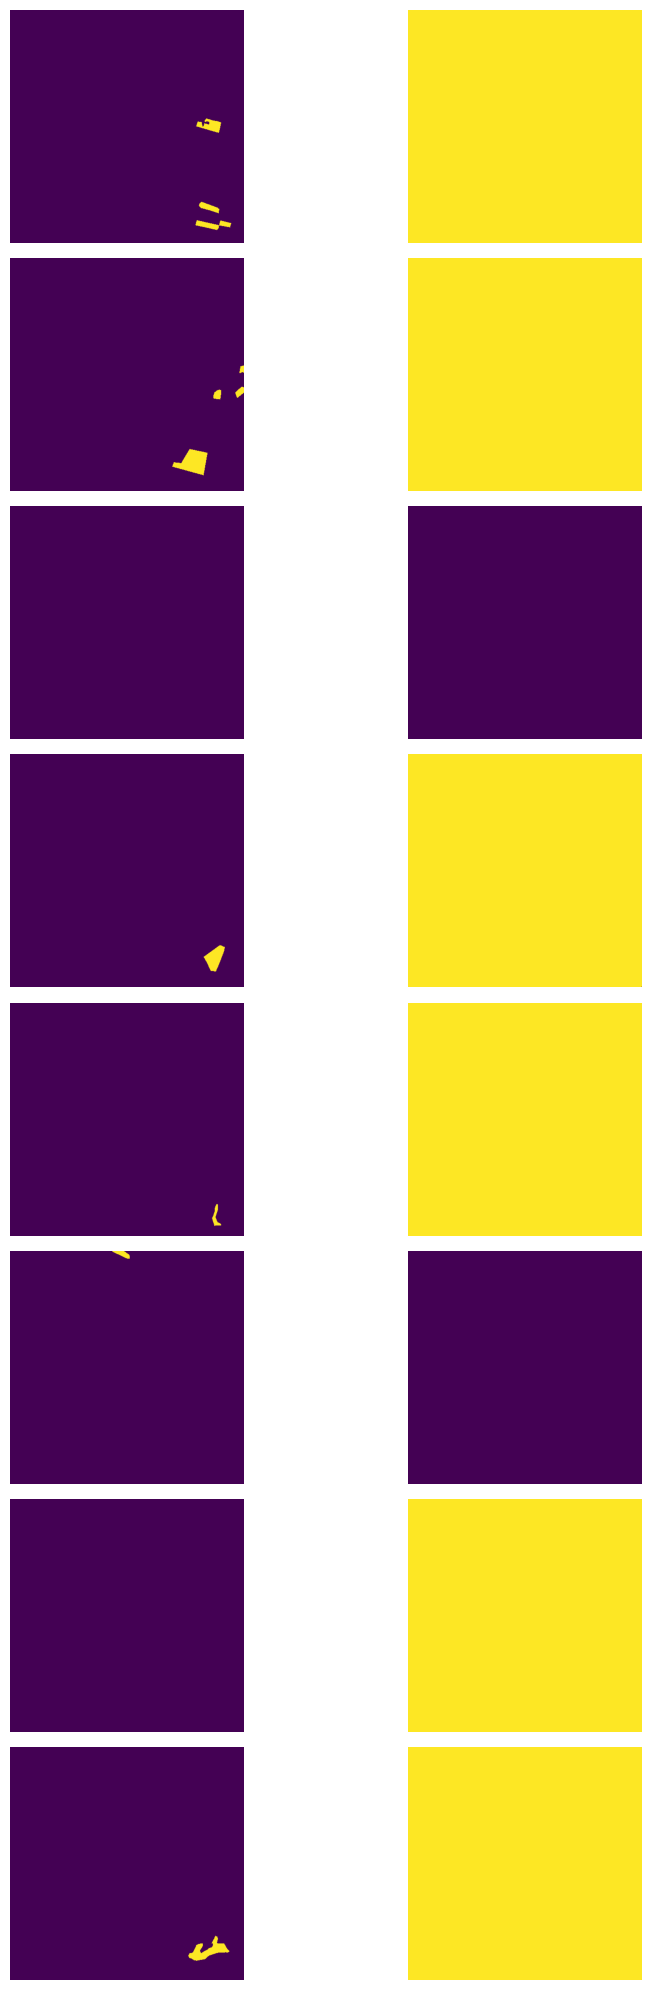

In [30]:
plt.figure(figsize=(10, 20))
for i in range(8):
  plt.subplot(8, 2, 2*i + 1)
  plt.axis('off')
  plt.imshow(mask_list[i])
  plt.subplot(8, 2, 2*i + 2)
  plt.axis('off')
  plt.imshow(out[i].squeeze().cpu().numpy())

plt.tight_layout()
plt.show()

In [110]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "/content/drive/MyDrive/deforestation_dataset/checkpoint.pth")



### Current Issues
- Imballanced Dataset, Deforested area is orders of magnitude less than forested area, can lead to always predicting forested for higher accuracy

- **Solution**:
  - Different Loss Function (DICE or Focal) https://ieeexplore.ieee.org/abstract/document/9575783?casa_token=oEsfy1aSeC8AAAAA:q6oB5Zmfy48JhEwNj1mVBPp5cJmAhKaGTREMTtAGDe8JwzTWmA2RctdrrFONbTNOSWgRwUDLic8
  - Different Metrics:
    - Precision / Recall
    - F1
    - IoU
    - **ROC AUC**


- Predictions are noisey and inconsistent, some sort of filtering or thresholding? Maybe another block in the network for post processing

- Converting predicted mask to geojson  --> pre-existing model

- Coarse to Fine approach

- Watershed Algo (Morphological Opps)

- Multi-scale u net

- Data Augmentation:
  - X & Y Flipping

In [ ]:
# fnames = []

# for i, (key, value) in enumerate(metadata.items()):
#     first_path = os.path.join(path, value['files']['satellite_img_first'])
#     second_name = os.path.join(path, value['files']['satellite_img_second'])
#     mask_name = os.path.join(path, value['files']['mask'])

#     fnames.append([first_path, second_name, mask_name])

#     # first_arr[i] = np.load(first_path)
#     # second_arr[i] = np.load(second_name)
#     # mask_arr[i] = np.load(mask_name)


# fnames = np.array(fnames)

# np.random.shuffle(fnames)

# first_img = np.load(fnames[0][0])
# second_img = np.load(fnames[0][1])
# mask_img = np.load(fnames[0][2])

# print(first_img.shape)
# print(second_img.shape)
# print(mask_img.shape)

# def normalize(rgb_data, stretch_percentile=1):
#   # Normalize and stretch contrast
#   rgb_normalized = np.zeros_like(rgb_data, dtype=np.float32)

#   for i in range(3):
#       band = rgb_data[:, :, i].astype(np.float32)

#       # Remove extreme values for better visualization
#       p_low = np.percentile(band, stretch_percentile)
#       p_high = np.percentile(band, 100 - stretch_percentile)

#       # Clip and normalize to 0-1
#       band = np.clip(band, p_low, p_high)
#       band = (band - p_low) / (p_high - p_low)

#       rgb_normalized[:, :, i] = band

#   # Clip to valid range
#   return np.clip(rgb_normalized, 0, 1)


# def get_bands(img, rgb_bands=[3,2,1]):
#   return img[:,:, rgb_bands]

# def vizualize(img, mask=None):
#   if len(img.shape) == 3:
#     img = get_bands(img)
#     img = normalize(img)

#   if mask is not None:
#     mask = np.stack((mask,)*3, axis=-1)
#     plt.imshow(img + mask)
#     plt.show()

#   else:
#     plt.imshow(img)
#     plt.show()




# vizualize(first_img)
# vizualize(second_img)
# vizualize(first_img, mask_img)

In [36]:
# In your project directory
!git clone https://github.com/tmcarn/deforestation_detection.git

Cloning into 'deforestation_detection'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [39]:
%cd deforestation_detection

!git config --global user.email "theo_mcarn@brown.edu"
!git config --global user.name "Theo"

# Add your files and push
!git add .
!git commit -m "Initial commit"
!git push origin main

[Errno 2] No such file or directory: 'deforestation_detection'
/content/deforestation_detection
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
